# Class activation maps

In this notebook, we have our model output a class activation map in addition to a single binary prediction of pneumonia. This map will help a clinician to understand what the model is detecting as probable pneumonia in each image.

This code is partly based on ["Class activation maps in Keras for visualizing where deep learning networks pay attention"](https://jacobgil.github.io/deeplearning/class-activation-maps) by Jacob Gil.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
# %matplotlib inline
# import matplotlib.pyplot as plt

##Import any other stats/DL/ML packages you may need here. E.g. Keras, scikit-learn, etc.
from itertools import chain
import sklearn.model_selection as skl
from random import sample 
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Conv2D, ZeroPadding2D, Convolution2D
# from keras.optimizers import Adam
# from numpy import arange
# from numpy import argmax
# from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, plot_precision_recall_curve, f1_score, confusion_matrix, fbeta_score
from tensorflow.keras.layers import Lambda

Using TensorFlow backend.


## Do some early processing of your metadata for easier model training:

In [2]:
## Below is some helper code to read all of your full image filepaths into a dataframe for easier manipulation
## Load the NIH data to all_xray_df
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/data','images*', '*', '*.png'))}
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)

In [3]:
## Here you may want to create some extra columns in your table with binary indicators of certain diseases 
## rather than working directly with the 'Finding Labels' column

all_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        all_xray_df[c_label] = all_xray_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)

In [4]:
## Here we can create a new column called 'pneumonia_class' that will allow us to look at 
## images with or without pneumonia for binary classification

def get_pneumonia_class(row):
    if row['Pneumonia'] < 0.5:
        return "no-pneumonia"
    else:
        return "pneumonia"

all_xray_df['pneumonia_class'] = all_xray_df.apply(lambda row: get_pneumonia_class(row), axis=1)

## Create your training and testing data:

In [5]:
def create_splits(df):
    
    ## Either build your own or use a built-in library to split your original dataframe into two sets 
    ## that can be used for training and testing your model
    ## It's important to consider here how balanced or imbalanced you want each of those sets to be
    ## for the presence of pneumonia
    
    train_data, val_data = skl.train_test_split(df, 
                                   test_size = 0.2, 
                                   stratify = all_xray_df['pneumonia_class'])
    
    return train_data, val_data

In [6]:
train_df, valid_df = create_splits(all_xray_df)

Great, our train_test_split made sure that we had the same proportions of pneumonia in both sets!

### Condition 1 - To have _EQUAL_ amount of positive and negative cases of pneumonia in Training 
But.... we know that we want our model to be trained on a set that has _equal_ proportions of pneumonia and no pneumonia, so we're going to have to throw away some data:

In [7]:
p_inds = train_df[train_df.Pneumonia==1].index.tolist()
np_inds = train_df[train_df.Pneumonia==0].index.tolist()

np_sample = sample(np_inds,len(p_inds))
train_df = train_df.loc[p_inds + np_sample]

Ta-da! We randomly chose a set of non-pneumonia images using the sample() function that was the same length as the number of true pneumonia cases we had, and then we threw out the rest of the non-pneumonia cases. Now our training dataset is balanced 50-50.

### Condition 2 - To have 20% positive cases of Pneumonia in the Test Set
Finally, we want to make the balance in our validation set more like 1:4.

In [8]:
p_inds = valid_df[valid_df.Pneumonia==1].index.tolist()
np_inds = valid_df[valid_df.Pneumonia==0].index.tolist()

In [9]:
# The following code pulls a random sample of non-pneumonia data that's 4 times as big as the pneumonia sample.
np_sample = sample(np_inds, 4 * len(p_inds))
valid_df = valid_df.loc[p_inds + np_sample]

In [10]:
p_inds = valid_df[valid_df.Pneumonia==1].index.tolist()
np_inds = valid_df[valid_df.Pneumonia==0].index.tolist()

# Now we can begin our model-building & training

#### First suggestion: perform some image augmentation on your data

In [11]:
## you can choose an image size to resize your images to during augmentation, which comes in handy later when you
## want to do deep learning using a pre-trained CNN that has a specified size input layer
IMG_SIZE = (224, 224)

In [12]:
def my_image_augmentation(**vargs):
    
    ## recommendation here to implement a package like Keras' ImageDataGenerator
    ## with some of the built-in augmentations 
    
    ## keep an eye out for types of augmentation that are or are not appropriate for medical imaging data
    ## Also keep in mind what sort of augmentation is or is not appropriate for testing vs validation data
    
    my_idg = ImageDataGenerator(rescale=1. / 255.0,
                              horizontal_flip = True, 
                              vertical_flip = False, 
                              height_shift_range= 0.1, 
                              width_shift_range=0.1, 
                              rotation_range=20, 
                              shear_range = 0.1,
                              zoom_range=0.1)
    
    return my_idg


def make_train_gen(my_train_idg, train_df):
    
    ## Create the actual generators using the output of my_image_augmentation for your training data
    ## Suggestion here to use the flow_from_dataframe library, e.g.:
    
    train_gen = my_train_idg.flow_from_dataframe(dataframe=train_df, 
                                          directory=None, 
                                          x_col = 'path',
                                          y_col = 'pneumonia_class',
                                          class_mode = 'binary',
                                          target_size = IMG_SIZE, 
                                          batch_size = 16)
    return train_gen


def make_val_gen(my_val_idg, val_data):
    
    val_gen = my_val_idg.flow_from_dataframe(dataframe = val_data, 
                                              directory=None, 
                                              x_col = 'path',
                                              y_col = 'pneumonia_class',
                                              class_mode = 'binary',
                                              target_size = IMG_SIZE, 
                                              batch_size = 128) 
    return val_gen

In [13]:
train_idg = my_image_augmentation(rescale=1. / 255.0,
                              horizontal_flip = True, 
                              vertical_flip = False, 
                              height_shift_range= 0.1, 
                              width_shift_range=0.1, 
                              rotation_range=20, 
                              shear_range = 0.1,
                              zoom_range=0.1)

In [14]:
val_idg = my_image_augmentation(rescale=1. / 255.0,
                              horizontal_flip = False, 
                              vertical_flip = False, 
                              height_shift_range= 0.0, 
                              width_shift_range=0.0, 
                              rotation_range=0, 
                              shear_range = 0.0,
                              zoom_range=0.0)

In [15]:
train_gen = make_train_gen(train_idg, train_df)

Found 2290 validated image filenames belonging to 2 classes.


In [16]:
val_gen = make_val_gen(val_idg, valid_df)

Found 1430 validated image filenames belonging to 2 classes.


In [17]:
## May want to pull a single large batch of random validation data for testing after each epoch:
valX, valY = val_gen.next()

## Build your model: 

Recommendation here to use a pre-trained network downloaded from Keras for fine-tuning

In [18]:
def global_average_pooling(x):
    return K.mean(x, axis = (2, 3))

def global_average_pooling_shape(input_shape):
    return input_shape[0:2]

In [19]:
def load_pretrained_model(lay_of_interest):
    
    model = VGG16(include_top=True, weights='imagenet')
    transfer_layer = model.get_layer(lay_of_interest)
    vgg_model = Model(inputs = model.input, outputs = transfer_layer.output)
    
    return vgg_model

In [23]:
def build_my_model():
    my_model = Sequential()
    # ....add your pre-trained model, and then whatever additional layers you think you might
    # want for fine-tuning (Flatteen, Dense, Dropout, etc.)
    vgg_model = load_pretrained_model('block5_pool')
    for layer in vgg_model.layers[0:17]:
        layer.trainable = False  
        
    for layer in vgg_model.layers:
        print(layer.name, layer.trainable)

    # Add the convolutional part of the VGG16 model from above.
    my_model.add(vgg_model)

    my_model.add(Flatten())
    my_model.add(Dropout(0.1))
    my_model.add(Dense(1024, activation='relu'))
    my_model.add(Dropout(0.1))
    my_model.add(Dense(512, activation='relu'))
    my_model.add(Dropout(0.1))
    my_model.add(Dense(256, activation='relu'))

## Choose another output layer besides just the last classification layer of your modele
## to output class activation maps to aid in clinical interpretation of your model's results    
    my_model.add(Lambda(global_average_pooling, output_shape=global_average_pooling_shape))

    my_model.add(Dense(1, activation='sigmoid'))

    # if you want to compile your model within this function, consider which layers of your pre-trained model, 
    # you want to freeze before you compile 
    
    # also make sure you set your optimizer, loss function, and metrics to monitor
    optimizer = Adam(lr=1e-5)  # Very low learning rate
    loss = 'binary_crossentropy'
    metrics = ['binary_accuracy']
    
    my_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

    return my_model

In [24]:
## Below is some helper code that will allow you to add checkpoints to your model,
## This will save the 'best' version of your model by comparing it to previous epochs of training

## Note that you need to choose which metric to monitor for your model's 'best' performance if using this code. 
## The 'patience' parameter is set to 10, meaning that your model will train for ten epochs without seeing
## improvement before quitting

weight_path="{}_my_model.best.hdf5".format('xray_class')

checkpoint = ModelCheckpoint(weight_path, 
                              monitor= 'val_loss', 
                              verbose=1, 
                              save_best_only=True, 
                              mode= 'min', 
                              save_weights_only = True)

early = EarlyStopping(monitor= 'val_loss', 
                       mode= 'min', 
                       patience=10)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=1e-6)

callbacks_list = [checkpoint, early, reduce_lr]

### Start training! 

In [25]:
## train your model

my_model = build_my_model()

input_2 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 False
block5_conv2 False
block5_conv3 True
block5_pool True


TypeError: The added layer must be an instance of class Layer. Found: <tensorflow.python.keras.layers.core.Lambda object at 0x7fc230013f90>

In [ ]:
history = my_model.fit_generator(train_gen, 
                           validation_data = (valX, valY), 
                           epochs = 100, 
                           callbacks = callbacks_list)

##### After training for some time, look at the performance of your model by plotting some performance statistics:

Note, these figures will come in handy for your FDA documentation later in the project

In [28]:
## After training, make some predictions to assess your model's overall performance
## Note that detecting pneumonia is hard even for trained expert radiologists, 
## so there is no need to make the model perfect.
my_model.load_weights(weight_path)
pred_Y = my_model.predict(valX, batch_size = 32, verbose = True)

128/128 [==============================] - 4s 35ms/step


In [29]:
def plot_auc(t_y, p_y):
    
    ## Hint: can use scikit-learn's built in functions here like roc_curve
    
    fpr, tpr, _ = roc_curve(t_y, p_y)
    plt.plot(fpr, tpr, label='Pneumonia')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()

## what other performance statistics do you want to include here besides AUC? 


# def ... 
def plot_roc_curve(t_y, p_y):
    fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
    fpr, tpr, thresholds = roc_curve(t_y, p_y)
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % ('Pneumonia', auc(fpr, tpr)))
    c_ax.legend()
    c_ax.set_xlabel('False Positive Rate')
    c_ax.set_ylabel('True Positive Rate')

# def ...
def plot_precision_recall_curve(t_y, p_y):
    fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
    precision, recall, thresholds = precision_recall_curve(t_y, p_y)
    c_ax.plot(recall, precision, label = '%s (AP Score:%0.2f)'  % ('Pneumonia', average_precision_score(t_y,p_y)))
    c_ax.legend()
    c_ax.set_xlabel('Recall')
    
#Also consider plotting the history of your model training:

def plot_history(history):
    N = len(history.history["loss"])
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
    plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
    plt.plot(np.arange(0, N), history.history["binary_accuracy"], label="train_acc")
    plt.plot(np.arange(0, N), history.history["val_binary_accuracy"], label="val_acc")
    plt.title("Training Loss and Accuracy on Dataset")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc="lower left")    

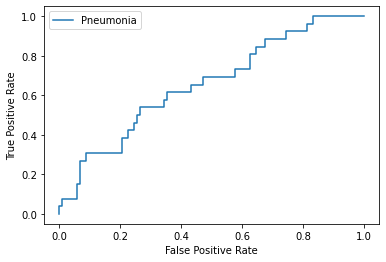

In [30]:
## plot figures

plot_auc(valY, pred_Y)

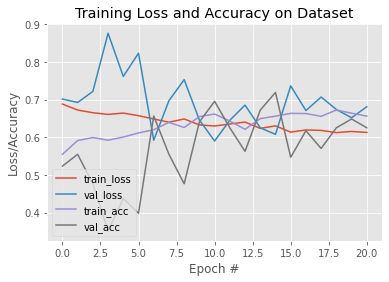

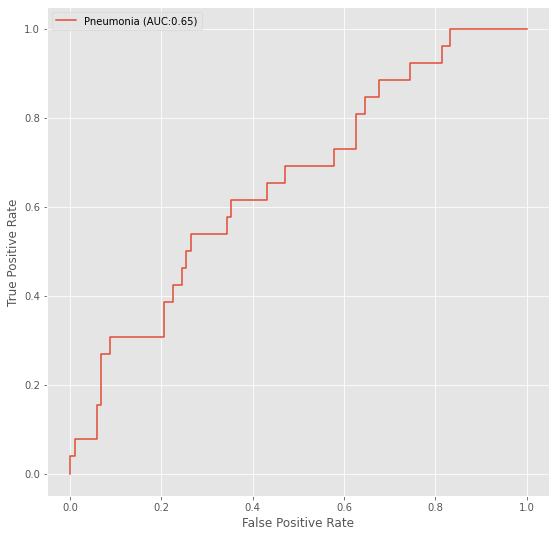

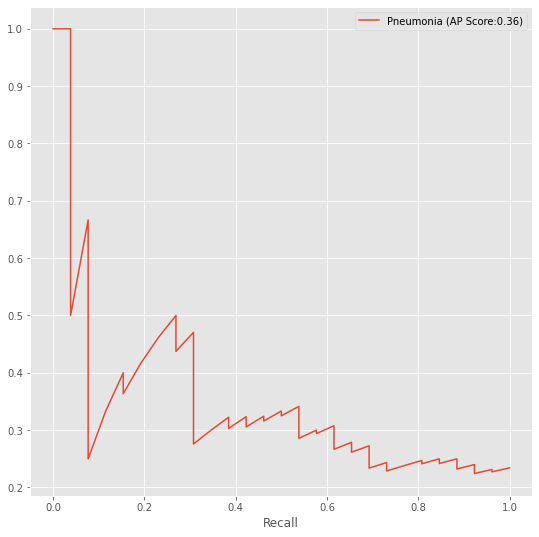

In [31]:
plot_history(history)
plot_roc_curve(valY, pred_Y)
plot_precision_recall_curve(valY, pred_Y)

Once you feel you are done training, you'll need to decide the proper classification threshold that optimizes your model's performance for a given metric (e.g. accuracy, F1, precision, etc.  You decide) 

### F1 score

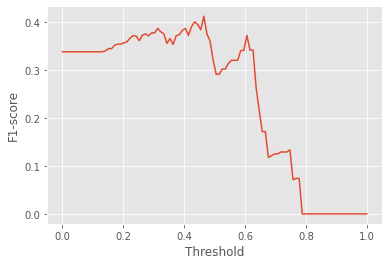

In [47]:
## Find the threshold that optimize your model's performance,
## and use that threshold to make binary classification. Make sure you take all your metrics into consideration.
thresholds = np.linspace(0.0, 1.0, 100)
f1_scores = []
confusion_matrices = []
n = len(pred_Y)
f_beta_scores = []
for threshold in thresholds:
    gated_pred_y = [1 if pred >= threshold else 0 for pred in pred_Y]
    score = f1_score(list(valY), gated_pred_y)
    matrix = confusion_matrix(valY, gated_pred_y)
    confusion_matrices.append(matrix)
    f1_scores.append(score)
    beta_score = fbeta_score(list(valY), gated_pred_y, beta=1.5)
    f_beta_scores.append(beta_score)
plt.plot(thresholds, f1_scores)
plt.xlabel("Threshold")
plt.ylabel("F1-score");

In [48]:
idx = list(f1_scores).index(max(f1_scores))
best_threshold = thresholds[idx]
best_f1_score = f1_scores[idx]
best_confusion_matrix = confusion_matrices[idx]

In [49]:
print('best_threshold:', best_threshold)

best_threshold: 0.4646464646464647


CheXNet achieves an F1 score of 0.435

In [36]:
print('f1_score:', best_f1_score)

f1_score: 0.41176470588235287


In [37]:
print('best_confusion_matrix:', best_confusion_matrix)

best_confusion_matrix: [[74 28]
 [12 14]]


We see that there are 12 false negatives out of 128 cases.  This is a false negative rate of about 10%.  For a medical model, false positives are okay, but false negatives are not okay.  To see whether we can drive down the frequency of false negatives, we will try using an F-beta score.  To minimize the number of false negatives, we need to maximize recall.

### F-beta score

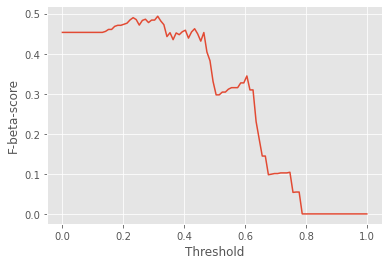

In [50]:
plt.plot(thresholds, f_beta_scores)
plt.xlabel("Threshold")
plt.ylabel("F-beta-score");

In [51]:
f_beta_idx = list(f_beta_scores).index(max(f_beta_scores))
f_beta_best_threshold = thresholds[f_beta_idx]
best_f_beta_score = f_beta_scores[f_beta_idx]
f_beta_best_confusion_matrix = confusion_matrices[f_beta_idx]

In [52]:
print('f_beta_best_threshold:', f_beta_best_threshold)

f_beta_best_threshold: 0.31313131313131315


In [53]:
print('best_f_beta_score:', best_f_beta_score)

best_f_beta_score: 0.4933993399339934


In [54]:
print('f_beta_best_confusion_matrix:', f_beta_best_confusion_matrix)

f_beta_best_confusion_matrix: [[32 70]
 [ 3 23]]


We've decreased the number of fall positives to 3 by increasing `beta` to 1.5 in our call to `fbeta_score`

### Example predictions

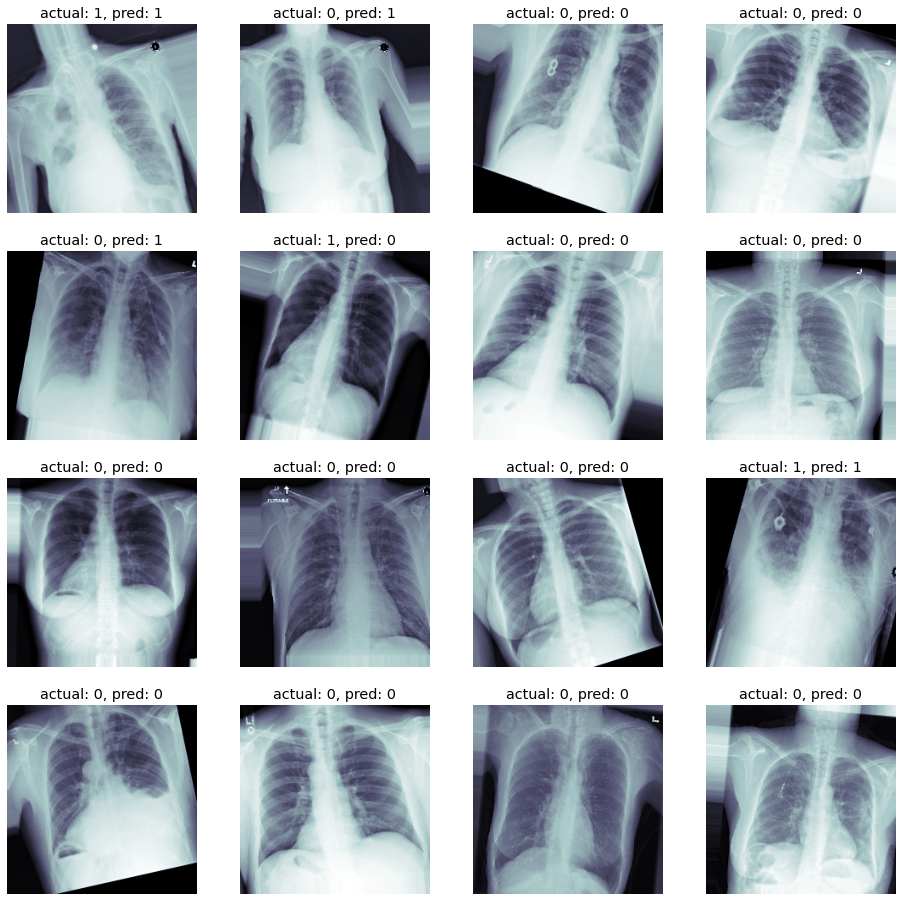

In [55]:
## Let's look at some examples of true vs. predicted with our best model: 

fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
i = 0
for (c_x, c_y, c_ax) in zip(valX[0:16], valY[0:16], m_axs.flatten()):
     c_ax.imshow(c_x[:,:,0], cmap = 'bone')
     if c_y == 1: 
         if pred_Y[i] > best_threshold:
             c_ax.set_title('actual: 1, pred: 1')
         else:
             c_ax.set_title('actual: 1, pred: 0')
     else:
         if pred_Y[i] > best_threshold: 
             c_ax.set_title('actual: 0, pred: 1')
         else:
             c_ax.set_title('actual: 0, pred: 0')
     c_ax.axis('off')
     i=i+1

In [56]:
## Just save model architecture to a .json:

model_json = my_model.to_json()
with open("my_model.json", "w") as json_file:
    json_file.write(model_json)